# ImmoCheck

This projects purpose is to give an overview how rent and buying prices of real estate changed in vienna over the last years. Therefore certain steps are taken. First of all data gets imported and gathered through different sources. Futher cleaning and stucturing will also be apllied. The main parts like data explanation, analysis and also visulations for better understanding will give you a better understanding on the topic. In the last part, conslusions will be drwan. The cleaned and stuctured data will also be provided as csv files. \
Let's get started!

## Imports

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import max, median, round
import pyspark 
import matplotlib.pyplot as plt
import json

In [29]:
!pip install pdfplumber pandas openpyxl odfpy

## Data Gathering

There will be four different sources of data. One Webscarping, one API and two files.

### Webscarping - Current cost of real estate

#### Load Data

To get data regarding current costs of real estate, data from the webside "Immobilienscout24.at" will be scraped.

In [30]:
i = 1
url = ""
prices = []
while True:
    if i == 1:
        url = 'https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen'
    else:
        url = f'https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-{i}'

    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    postings = soup.find_all('li', {'class': 'Item-item-S33'})
    i += 1
    scraped_vals = 0
    for ele in postings:
        for ele2 in (ele.select('a > section > section:nth-of-type(2) > ul:nth-of-type(1) > li:nth-of-type(2)')):
            prices.append(ele2.getText())
            scraped_vals += 1
    if postings == []:
        break;

    print(url,' scraped values:',scraped_vals)

https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen  scraped values: 13
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-2  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-3  scraped values: 13
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-4  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-5  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-6  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-7  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-8  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-9  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-10  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnu

The scraped values get converted in a pandas dataFrame.

In [60]:
export_dict = {'vals':prices}
export_df = pd.DataFrame(export_dict)
export_df.head(10)

,vals
0,"ab 5.189,5 €/m²"
1,"ab 7.591,67 €/m²"
2,"ab 2.468,11 €/m²"
3,"ab 8.353,58 €/m²"
4,"ab 16.479,28 €/m²"
5,"ab 9.035,75 €/m²"
6,"ab 5.395,68 €/m²"
7,"ab 7.409,54 €/m²"
8,ab 4.921 €/m²
9,"ab 5.937,36 €/m²"


Looks good, but for further processing we just need the values.

In [61]:
export_df = export_df.replace('ab','',regex = True)
export_df = export_df.replace('€/m²','',regex = True)
export_df = export_df.replace(' ','',regex = True)
export_df.head(10)

,vals
0,"5.189,5"
1,"7.591,67"
2,"2.468,11"
3,"8.353,58"
4,"16.479,28"
5,"9.035,75"
6,"5.395,68"
7,"7.409,54"
8,4.921
9,"5.937,36"


Now the format has to be adapted.

In [62]:
export_df = export_df.apply(lambda x: x.str.replace('.',''))
export_df = export_df.replace(',','.',regex = True)
export_df.head(10)

,vals
0,5189.5
1,7591.67
2,2468.11
3,8353.58
4,16479.28
5,9035.75
6,5395.68
7,7409.54
8,4921
9,5937.36


Most of the values look good. However, wile scarping we also got some value which can not be further processed.

In [63]:
export_df[export_df['vals'].str.startswith('statt')]

,vals
98,statt279000€-10%
99,statt458000€-14%
130,statt229000€-10%
134,statt269000€-9%
211,statt515000€-5%
214,statt990000€-9%
268,statt539000€-8%
279,statt369000€-8%
297,statt315000€-6%
436,statt270000€-8%


These values get deleted.

In [64]:
export_df = export_df.drop([98,99,130,134,211,214,268,279,297,436,474,491,506,589])

Now the value look good and are ready to be exported for later processing.

In [65]:
export_df.to_csv('./exports/prices.csv', index=False)  

#### Analysis

To get a deeper understanding of the data we want to take advantage of a visualation. Therefore, we need to load the already structered and cleaned data again.

In [66]:
spark = SparkSession \
    .builder \
    .appName("ImmoCheck") \
    .getOrCreate()
df = spark.read.csv("./exports/prices.csv",header = True)
print(df)
df.show(5)

DataFrame[vals: string]
+--------+
|    vals|
+--------+
|  5189.5|
| 7591.67|
| 2468.11|
| 8353.58|
|16479.28|
+--------+
only showing top 5 rows



The values are loaded. However we have to set the type to float, for using visulations.

In [67]:
df = df.withColumn("vals", df["vals"].cast("float"))
df

DataFrame[vals: float]

<Axes: >

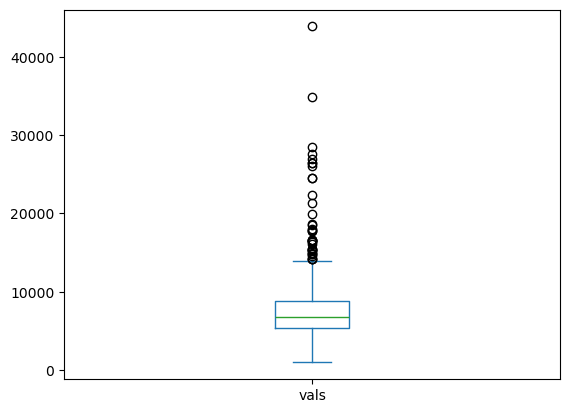

In [68]:
df_p = df.select('*').toPandas()
df_p.dtypes
df_p['vals'] = df_p['vals'].astype('float64')
df_p["vals"].plot.box() 

Beschreibung Markus!!!!!!!!!

In [69]:
df_median = df.select(round(median('vals')))
df_median.show()

+----------------------+
|round(median(vals), 0)|
+----------------------+
|                6795.0|
+----------------------+



The value of the median of our data set is 6795 per square meter.

### Datasource 2 - Historical cost of real estate

In [7]:
# Datei einlesen und den spezifischen Reiter "Wien" laden
file_path = './statistik austria/Wohnungspreise2016.ods'

# Den ODS-Reader verwenden und den Reiter "Wien" laden
df_wien = pd.read_excel(file_path, engine='odf', sheet_name='Wien', header=[3, 4])

# Unnötige Spalten entfernen, falls erforderlich
df_wien = df_wien.dropna(axis=1, how='all')

# Ergebnis anzeigen
print(df_wien.head())

         Unnamed: 0_level_0 Wohnfläche nach Baujahr              \
                    Bezirke                Bis 1960  Bis 1960.1   
0                       NaN       Weniger als 56 m²  56 - 80 m²   
1  Wien  1.,Innere Stadt 3)                    5901        5901   
2     Wien  2.,Leopoldstadt                    2533        2532   
3       Wien  3.,Landstraße                    2782        2819   
4           Wien  4.,Wieden                    3050        2944   

                                                                    \
        Bis 1960.2          1961-1990 1961-1990.1      1961-1990.2   
0  Mehr als  80 m²  Weniger als 56 m²  56 - 80 m²  Mehr als  80 m²   
1             5901               4067        4067             4067   
2             2534               2748        2747             2749   
3             2862               2710        2746             2788   
4             3076               2738        2643             2761   

                                       

In [8]:
# Letzte Spalte identifizieren
last_column = df_wien.columns[-1]

# Konvertiere die Spalte in einen numerischen Datentyp (falls nötig)
df_wien[last_column] = pd.to_numeric(df_wien[last_column], errors='coerce')

# Mittelwert berechnen
mean_value = df_wien[last_column].mean()

print(f"Der Mittelwert der letzten Spalte '{last_column[1]}' beträgt: {mean_value}")

Der Mittelwert der letzten Spalte 'Ab 1991.2' beträgt: 4577.369565217391


In [4]:
# Liste der Dateipfade und entsprechenden Jahre
files = [
    ('./statistik austria/Wohnungspreise2016.ods', 2016),
    ('./statistik austria/Wohnungspreise2017.ods', 2017),
    ('./statistik austria/Wohnungspreise2018.ods', 2018),
    ('./statistik austria/Wohnungspreise2019.ods', 2019),
    ('./statistik austria/Wohnungspreise2020.ods', 2020),
    ('./statistik austria/Wohnungspreise2021.ods', 2021),
    ('./statistik austria/Wohnungspreise2022.ods', 2022),
]

# Funktion, um den Mittelwert der letzten Spalte für ein spezifisches Sheet zu berechnen
def calculate_mean(file_path, sheet_name='Wien'):
    df = pd.read_excel(file_path, engine='odf', sheet_name=sheet_name, header=[3, 4])
    df = df.dropna(axis=1, how='all')
    last_column = df.columns[-1]
    df[last_column] = pd.to_numeric(df[last_column], errors='coerce')
    return df[last_column].mean()

# Dictionary, um die Ergebnisse zu speichern
results = {}

# Schleife durch die Dateien und berechne den Mittelwert
for file_path, year in files:
    mean_value = calculate_mean(file_path)
    results[year] = mean_value

# Daten für 2015 einlesen, bereinigen und den Mittelwert berechnen
file_path_2015 = './statistik austria/Wohnungspreise2015.ods'
sheet_name_2015 = 'Wohnungen_ohne_Außenflächen'
df_2015_ohne_außenflächen = pd.read_excel(file_path_2015, engine='odf', sheet_name=sheet_name_2015, header=[2, 3])
df_2015_ohne_außenflächen_cleaned = df_2015_ohne_außenflächen.dropna(axis=1, how='all')

# Zeilen für Wiener Bezirke extrahieren
vienna_districts_2015 = df_2015_ohne_außenflächen_cleaned[
    df_2015_ohne_außenflächen_cleaned.iloc[:, 0].str.contains(
        'Innere Stadt|Leopoldstadt|Landstraße|Wieden|Margareten|Mariahilf|Neubau|Josefstadt|Alsergrund|Favoriten|Simmering|Meidling|Hietzing|Penzing|Rudolfsheim-Fünfhaus|Ottakring|Hernals|Währing|Döbling|Brigittenau|Floridsdorf|Donaustadt|Liesing',
        na=False
    )
]
last_column_2015 = vienna_districts_2015.columns[-1]
vienna_districts_2015[last_column_2015] = pd.to_numeric(vienna_districts_2015[last_column_2015], errors='coerce')
mean_value_2015 = vienna_districts_2015[last_column_2015].mean()

# Füge den Wert für 2015 zu den vorhandenen Ergebnissen hinzu
results[2015] = mean_value_2015

# Konvertiere die Ergebnisse in ein DataFrame
results_df = pd.DataFrame(list(results.items()), columns=['Year', 'Mean']).sort_values('Year').reset_index(drop=True)

# Berechne die prozentuale Veränderung
results_df['Percentage Change'] = results_df['Mean'].pct_change() * 100

# Ergebnisse anzeigen
print(results_df)

# Error message can be ignored!

   Year         Mean  Percentage Change
0  2015  2948.181818                NaN
1  2016  4577.369565          55.260762
2  2017  4910.804348           7.284419
3  2018  5108.978261           4.035467
4  2019  5667.304348          10.928332
5  2020  5947.521739           4.944456
6  2021  6311.673913           6.122755
7  2022  6994.673913          10.821218


C:\Users\benni\AppData\Local\Temp\ipykernel_23408\1950597965.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vienna_districts_2015[last_column_2015] = pd.to_numeric(vienna_districts_2015[last_column_2015], errors='coerce')


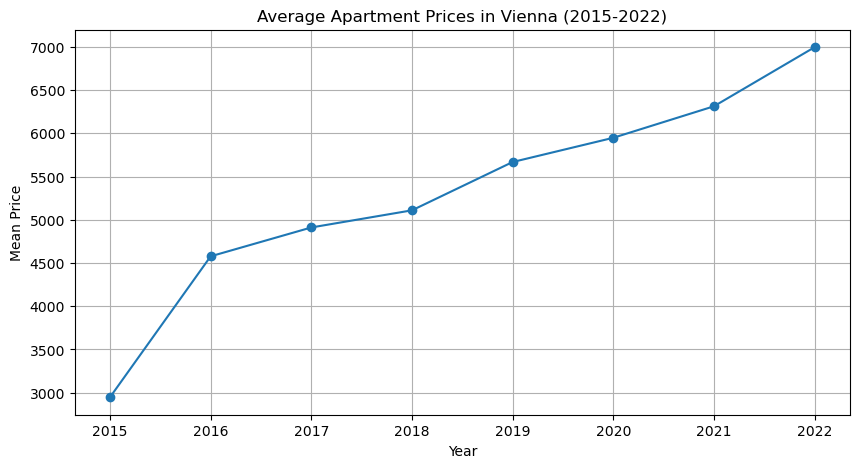

In [11]:
# Plot the mean values per year
plt.figure(figsize=(10, 5))
plt.plot(results_df['Year'], results_df['Mean'], marker='o', linestyle='-')
plt.title('Average Apartment Prices in Vienna (2015-2022)')
plt.xlabel('Year')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()

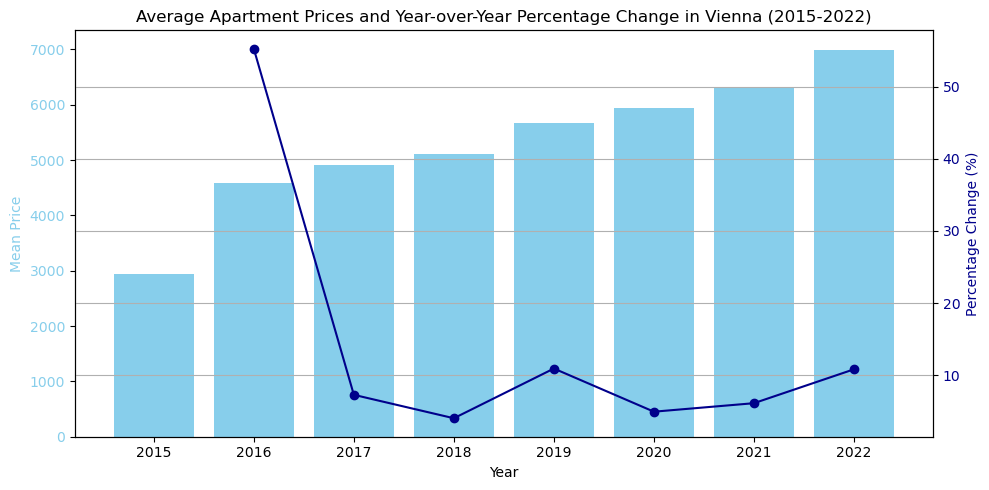

In [12]:
# Plot the mean values per year as a bar chart
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(results_df['Year'], results_df['Mean'], color='skyblue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Price', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Average Apartment Prices and Year-over-Year Percentage Change in Vienna (2015-2022)')

# Create a secondary y-axis to plot the percentage change
ax2 = ax1.twinx()
ax2.plot(results_df['Year'], results_df['Percentage Change'], color='darkblue', marker='o', linestyle='-')
ax2.set_ylabel('Percentage Change (%)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

fig.tight_layout()  # Ensure everything fits without overlapping
plt.grid(True)
plt.show()

### Datasource 3 - Historical population total 

In [14]:
# API abrufen
url_population = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/demo_r_d2jan?format=JSON&time=2015&time=2016&time=2017&time=2018&time=2019&time=2020&time=2021&time=2022&time=2023&geo=AT&geo=AT1&geo=AT11&geo=AT12&geo=AT13&geo=AT2&geo=AT21&geo=AT22&geo=AT3&geo=AT31&geo=AT32&geo=AT33&geo=AT34&unit=NR&sex=T&age=TOTAL&lang=en"
response = requests.get(url_population)
data = response.json()

In [15]:
print(json.dumps(data, indent=4))

{
    "version": "2.0",
    "class": "dataset",
    "label": "Population on 1 January by age, sex and NUTS 2 region",
    "source": "ESTAT",
    "updated": "2024-05-16T23:00:00+0200",
    "value": {
        "0": 8584926,
        "1": 8700471,
        "2": 8772865,
        "3": 8822267,
        "4": 8858775,
        "5": 8901064,
        "6": 8932664,
        "7": 8978929,
        "8": 9104772,
        "9": 3722471,
        "10": 3784928,
        "11": 3825277,
        "12": 3852119,
        "13": 3868466,
        "14": 3889914,
        "15": 3907838,
        "16": 3927972,
        "17": 4001720,
        "18": 288356,
        "19": 291011,
        "20": 291942,
        "21": 292675,
        "22": 293433,
        "23": 294436,
        "24": 296010,
        "25": 297583,
        "26": 301250,
        "27": 1636778,
        "28": 1653691,
        "29": 1665753,
        "30": 1670668,
        "31": 1677542,
        "32": 1684287,
        "33": 1690879,
        "34": 1698796,
        "35": 1

In [21]:
pd.set_option('display.max_rows', None)
years = data['dimension']['time']['category']['label'].keys()
regions = []
geocodes = []

for x in data['dimension']['geo']['category']['label'].values():
    for y in range(9):
        regions.append(x)

for x in data['dimension']['geo']['category']['label'].keys():
    for y in range(9):
        geocodes.append(x)

# Erstellen eines DataFrames
population = pd.DataFrame(
    {'GeoCode' : geocodes,
     'Region' : regions,
     'Year': list(years) * 13,
     'Population': list(data['value'].values())
     }
)

In [22]:
print(data['dimension']['geo']['category']['label'].values())

dict_values(['Austria', 'Ostösterreich', 'Burgenland', 'Niederösterreich', 'Wien', 'Südösterreich', 'Kärnten', 'Steiermark', 'Westösterreich', 'Oberösterreich', 'Salzburg', 'Tirol', 'Vorarlberg'])


In [23]:
population = population.loc[(population['Region']=='Wien')]
print(population)

   GeoCode Region  Year  Population
36    AT13   Wien  2015     1797337
37    AT13   Wien  2016     1840226
38    AT13   Wien  2017     1867582
39    AT13   Wien  2018     1888776
40    AT13   Wien  2019     1897491
41    AT13   Wien  2020     1911191
42    AT13   Wien  2021     1920949
43    AT13   Wien  2022     1931593
44    AT13   Wien  2023     1982097


In [24]:
print(years)

dict_keys(['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])


In [8]:
# Beispiel-Daten in ein DataFrame laden
data = {
    'GeoCode': ['AT13'] * 9,
    'Region': ['Wien'] * 9,
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Population': [1797337, 1840226, 1867582, 1888776, 1897491, 1911191, 1920949, 1931593, 1982097]
}

population = pd.DataFrame(data)

# GeoCode-Spalte löschen
population = population.drop(columns=['GeoCode'])

# Prozentuale Veränderung der Bevölkerung berechnen
population['Percentage Change'] = population['Population'].pct_change() * 100

# Ergebnis anzeigen
print(population)

  Region  Year  Population  Percentage Change
0   Wien  2015     1797337                NaN
1   Wien  2016     1840226           2.386253
2   Wien  2017     1867582           1.486557
3   Wien  2018     1888776           1.134836
4   Wien  2019     1897491           0.461410
5   Wien  2020     1911191           0.722006
6   Wien  2021     1920949           0.510572
7   Wien  2022     1931593           0.554101
8   Wien  2023     1982097           2.614629


#### Analysis

Wir visualisieren die Bevölkerungsentwicklung nun als Liniendiagramm:

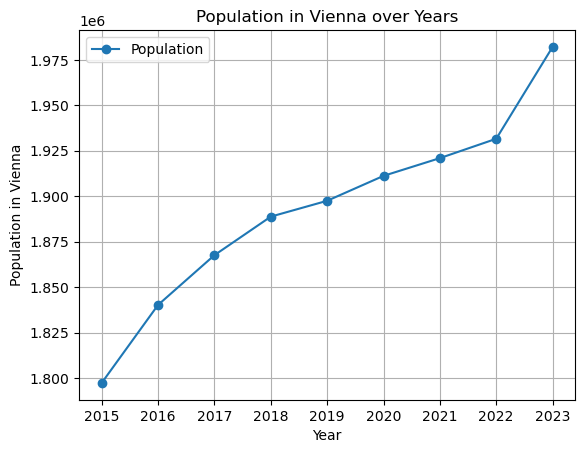

In [74]:
plt.plot(population['Year'], population['Population'], marker='o', label='Population')
plt.xlabel('Year')
plt.ylabel('Population in Vienna')
plt.title('Population in Vienna over Years')
plt.grid(True)
plt.legend()
plt.show()

Als erstes muss festgestellt werden, dass wir hier keine Daten für 2024 haben, dafür jedoch Daten von 2023, welche ebenfalls einen signifikanten Anstieg in diesem Jahr darstellen. Zuvor schien das Bevölkerungswachstum ein wenig abzuflachen und nach einem starken Wachstum in den Jahren von 2015 bis 2018 fiel es zwischen 2018 und 2022 nicht so stark aus.

## Gerneral Analysis

### Cost of real estate (2015 - 2024)

First we combine the historical property cost (2015-2022) with the current property cost (gathered by using Webscraping on the current - 2024 data).

In [70]:
#Median von CSV/Kafka importieren
median_2024 = df_median.collect()[0][0]

# Die neue Zeile für 2024 erstellen
val_2024 = pd.DataFrame({'Year': [2024], 'Mean': [median_2024], 'Percentage Change': [None]})

# Zeile zum DataFrame hinzufügen
all_results = pd.concat([results_df, val_2024], ignore_index=True)

# DataFrame anzeigen
print(all_results)

#Fehlermeldung kann ignoriert werden.

   Year         Mean  Percentage Change
0  2015  2948.181818                NaN
1  2016  4577.369565          55.260762
2  2017  4910.804348           7.284419
3  2018  5108.978261           4.035467
4  2019  5667.304348          10.928332
5  2020  5947.521739           4.944456
6  2021  6311.673913           6.122755
7  2022  6994.673913          10.821218
8  2024  6795.000000                NaN


C:\Users\benni\AppData\Local\Temp\ipykernel_23408\747221787.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([results_df, val_2024], ignore_index=True)


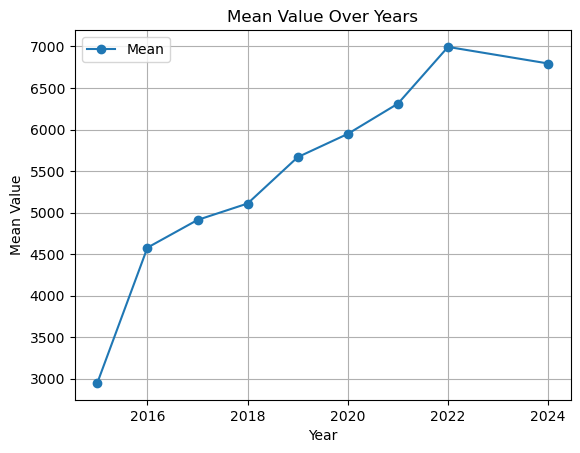

In [71]:
plt.plot(all_results['Year'], all_results['Mean'], marker='o', label='Mean')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.title('Mean Value Over Years')
plt.grid(True)
plt.legend()
plt.show()

Es zeigt sich das die aktuellen Daten auf einen leichten Abfall nach 2022 hindeuten. Zuvor stiegen der Median der Eigentumskosten pro m² kontinuirlich an. Der stärkste Anstieg ist ganz am Anfang der Daten von 2015 auf 2016 zu erkennen. Danach folgte ein kontinuirlicher Anstieg, welcher laut diesen Daten 2022 zum Stoppen kam und sich in einen leichten Abfall für 2024 umwandelte.

### Comparison with population growth

Nun vergleichen wir den Wachstum der Bevölkerung mit dem Anstieg der durchschnittlichen Eigentumskosten.

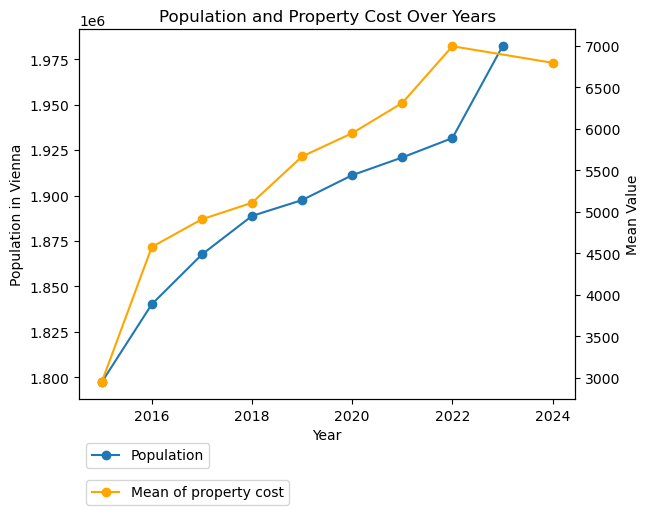

In [75]:
fig, ax = plt.subplots()

ax.plot(population['Year'], population['Population'], marker='o', label='Population')
ax.set_xlabel('Year')
ax.set_ylabel('Population in Vienna')

ax2 = ax.twinx()

ax2.plot(all_results['Year'], all_results['Mean'], marker='o', label='Mean of property cost', color='orange')
ax2.set_ylabel('Mean Value')

ax.legend(loc='upper left', bbox_to_anchor=(0, -0.1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, -0.2))

plt.title('Population and Property Cost Over Years')

plt.show()

Während anfangs die Eigentumskosten stärker als die Bevölkerung anstieg konnte das Bevölkerungswachstum im Jahr 2023 gepaart mit dem leichten Abfall der Eigentumskosten im Jahr 2024 dafür sorgen das über den gesamten Beobachtungszeitraum beide Anstiege in etwa gleich stark sind. Da die Anstiege innerhalb dieses Zeitraums jedoch zu unterschiedlichen Zeitpunkten erfolgt sind, heißt dies noch nicht zwangsläufig dass es sich hier auch um eine nachgewiesene Korrelation zwischen den beiden Werten handelt.

## Conclusion

Die Daten zeigen, dass es in den letzten 9 Jahren einen klaren Anstieg an Einwohnern und Eigentumskosten in der Bundeshauptstadt Wien gegeben hat. Dies hat diverse Gründe, welche nicht teil dieser Untersuchung sind und waren. Da diese Anstiege zumindest in Höhe ungefähr gleich stark sind, ist eine Korrelation nicht ausgeschlossen, sondern sogar wahrscheinlich. Dagegen würde jedoch sprechen, dass im Laufe dieser Jahre der Anstieg indivduell unterschiedlich ausgefallen ist und erst durch das starke Bevölkerungswachstum in 2023 und der Rückgang der Eigentumskosten im Jahr 2024 dafür gesorgt haben, dass die jeweiligen Anstiege in Summe ungefähr gleich stark ausfallen.
Auch muss für eine weitere Analyse berücksichtigt werden, dass die Datenquellen der Daten von 2024 und 2015-2022 unterschiedlich sind. Es kann durch diverse Faktoren dazu kommen, dass die eine oder die andere Datenquelle in eine gewisse Richtung verzerrt.

## Closing

In [36]:
spark.stop()